# Классификация отзывов КиноПоиска

В данной работе я на небольшом наборе данных постараюсь провести классификацию отзывов с сайта КиноПоиска с использованием нейросетей. Основная идея - получить наилучший результат классификации по трем категориям отзывов: положительные, отрицательные и нейтральные. Так же я выдвигаю гипотезу, что нейтральные отзывы существенно снижают точность классификации из-за своей невыраженной эмоциональной окраски. Последним шагом исследования будет исключение этой категории из датасета и проверка гипотезы.

Для анализа я использую самостоятельно собранный датасет из 3000 отзывов по 1000 в каждой категории.

## Комментарии к парсеру отзывов.

К проекту приложен файл 'parse_kinopoisk_reviews.py' с кодом, который я использовал для сбора отзывов. Думаю, стоит дать комментарии к нему, так как данный код исполнялся примерно 40 минут, что, конечно же, долго.

К сожалению сервис КиноПоиска не предоставляет официального API, поэтому пришлось прибегать к прямому парсингу страниц. Кроме того, в ходе экспериментов выяснилось, что автоматические запросы сайт банит очень быстро. Не помогает ни передача user-agent, ни расставленные time.sleep с рандомными значениями. Динамическая смена ip помогла на сборе id фильмов, но при парсинге отзывов по этим id сайт все равно банил запросы. Поэтому последним и успешным решением стало использование selenium.

По поводу логики парсинга в целом: я не смог выявить закономерность назначения id для фильмов. То есть, например, фильм с id 1000 может существовать, а 1001 - нет. Поэтому возник вопрос, где взять реально существующие id фильмов. Для этого я искал списки на сайте кинопоиска с максимальным количеством фильмов в нем. Этим списком оказался список с "фильмами, входящими в наибольшее количество списков" ('https://www.kinopoisk.ru/top/lists/223/). К сожалению, в данном списке фильмы, оцененные в основном положительно, поэтому простой сбор отзывов вызвал бы сильный дисбаланс между положительными и отрицательными отзывами. Поэтому в скрипте поставлено ограничение на размер датасета. В принципе, сбор отзывов закончился на 55 фильме (из 1036 доступных), поэтому ничто не мешает продолжить сбор отзывов пока хватает терпения.

Пасер сохраняет отзывы в файл json, который здесь я импортирую и выполню анализ.

## Шаг 1. Импорт датасета и предобработка.

Трансформацию текстовых отзывов в числовые тензоры я буду выполнять с помощью средств фрейморка keras.

In [0]:
import json
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
with open("reviews_data.json", "r") as read_file:
    load_data = json.load(read_file)

In [139]:
reviews = []
reviews += load_data['good']
reviews += load_data['bad']
reviews += load_data['neutral']
len(reviews)

3000

In [140]:
labels = [1 for _ in range(1000)] + [-1 for _ in range(1000)] + [0 for _ in range(1000)]
len(labels)

3000

Назначу константы, которые буду передавать в параметры слоев нейросетей.

max_len - длина отзыва. Отзыв будет обрезаться до 500-го слова.

training_samples - размер тренировочной выборки.

max_words - для работы нейросетей будет использоваться только 10000 наиболее часто встречаемых слов.

In [0]:
max_len = 500
training_samples = 2400
max_words = 10000

Создание индекса всех слов датасета производится с помощью следующих команд:

In [0]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

Преобразования каждого отзыва в массив индексов:

In [142]:
sequences = tokenizer.texts_to_sequences(reviews)
len(sequences)

3000

Создание словара: ключ - слово, значение - числовой индекс. Пригодится для работы с предварительно обученными векторными представлениями слов.

In [0]:
word_index = tokenizer.word_index

Преобразование списков целых чисел в тензоры с заданной формой:

In [144]:
data = pad_sequences(sequences, maxlen=max_len)
len(data)

3000

In [0]:
labels = np.asarray(labels)

Категоризацию отзывов я произведу с помощью отдельной функции.

In [146]:
def to_one_hot(labels, dimension=3):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

labels = to_one_hot(labels)
labels.shape

(3000, 3)

Последний шаг предобработки - перемешаю упорядоченные отзывы и разделю их на тестовые и тренировочные.

In [0]:
indices = np.arange(3000)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [0]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_test = data[training_samples:]
y_test = labels[training_samples:]

## Шаг 2. Обучение без использования предварительно обученных векторных представлений.

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

Моя сеть будет состоять из следующих слоев: Embedding - слой, связывающий числовые представления слов в векторные представления, Flatten - "выравнивающий" слой, Dense - полносвязный слой с 32 нейронами и еще один с 3 выводами по количеству категорий.

In [18]:
simple_model = Sequential()
simple_model.add(Embedding(max_words, 300, input_length=max_len))
simple_model.add(Flatten())
simple_model.add(Dense(32, activation='relu'))
simple_model.add(Dense(3, activation='softmax'))
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 150000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4800032   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 7,800,131
Trainable params: 7,800,131
Non-trainable params: 0
_________________________________________________________________


In [19]:
simple_model.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['acc'])
simple_model_history = simple_model.fit(X_train, y_train,
                                        epochs=10,
                                        batch_size=32,
                                        validation_split=0.2)

1920/1920 [==============================] - 8s 4ms/step - loss: 1.3003 - acc: 0.3807 - val_loss: 1.0473 - val_acc: 0.4646
Epoch 2/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.6731 - acc: 0.6672 - val_loss: 0.8489 - val_acc: 0.6167
Epoch 3/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.1758 - acc: 0.9370 - val_loss: 0.9866 - val_acc: 0.6125
Epoch 4/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.0102 - acc: 0.9995 - val_loss: 1.0820 - val_acc: 0.5625
Epoch 5/10
1920/1920 [==============================] - 7s 4ms/step - loss: 8.9307e-04 - acc: 1.0000 - val_loss: 1.2059 - val_acc: 0.5792
Epoch 6/10
1920/1920 [==============================] - 7s 4ms/step - loss: 4.9915e-05 - acc: 1.0000 - val_loss: 1.2510 - val_acc: 0.5729
Epoch 7/10
1920/1920 [==============================] - 7s 4ms/step - loss: 6.2580e-06 - acc: 1.0000 - val_loss: 1.3417 - val_acc: 0.5792
Epoch 8/10
1920/1920 [==============================] - 7s 4m

Визуализирую процесс обучения сети

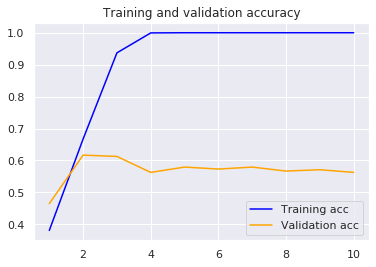

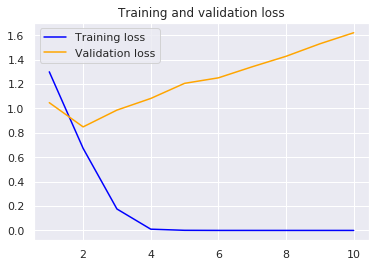

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

def plotting(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='orange', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plotting(simple_model_history)

In [21]:
simple_model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 386us/step


[1.2451126956939698, 0.6499999992052714]

Модель быстро достигает состояния переобучения и в целом показывает плохой результат. Хотя 65 % правильно классифицированных отзывов выше случайного угадывания, тем не менее результат неудовлетворительный.

## Шаг 3. Обучение с предварительно обученными векторными предствалениями слов.

Для русского языка существуют предварительно обученные векторные представления слов в пакете gensim.

In [22]:
import gensim
import gensim.downloader as download_api
russian_model = download_api.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [23]:
len(russian_model.vocab.keys())

184973

Подозрительно, что словарь (или корпус, как принято называть) имеет слишком мало слов. К примеру, словарь из моих 3000 отзывов имеет примерно 100000 слов. Это может ухудшить результаты, так как будет просто очень много пропусков при сравнивании словарей в поисках весовых матриц.

In [24]:
list(russian_model.vocab.keys())[0]

'весь_DET'

Еще одна неприятная неожиданность состоит в том, что в словаре к каждому слову приклеена его часть речи. Таким образом, напрямую забрать веса для своих слов я не смогу. Поэтому я заведу отдельный почищенный от частей речи словарь, буду вытаскивать индексы из сравнения своих слов со словами этого чистого словаря и после по индексам буду вытаскивать веса из изначального словаря russian_model.

In [25]:
import re

russian_dict = []
for x in list(russian_model.vocab.keys()):
    russian_dict.append(re.sub(r'_\w*', '', x))
len(russian_dict)

184973

In [0]:
embedding_matrix = np.zeros((max_words, 300))
for word, i in word_index.items():
    if i < max_words:
        try:
            word_index = russian_dict.index(word)
            word_in_model = list(russian_model.vocab.keys())[word_index]
            embedding_vector = russian_model.get_vector(word_in_model)
        except ValueError:
            embedding_vector = None 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Структуру сети я оставляю прежней, просто добавляю на первый слой матрицу весов из предварительно обученного векторного представления.

In [27]:
vector_model = Sequential()
vector_model.add(Embedding(max_words, 300, input_length=max_len))
vector_model.add(Flatten())
vector_model.add(Dense(32, activation='relu'))
vector_model.add(Dense(3, activation='softmax'))
vector_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 150000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4800032   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 7,800,131
Trainable params: 7,800,131
Non-trainable params: 0
_________________________________________________________________


In [0]:
vector_model.layers[0].set_weights([embedding_matrix])
vector_model.layers[0].trainable = False

In [29]:
vector_model.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['acc'])
vector_model_history = vector_model.fit(X_train, y_train,
                                        epochs=10,
                                        batch_size=32,
                                        validation_split=0.2)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 5s 3ms/step - loss: 1.0970 - acc: 0.3667 - val_loss: 1.0923 - val_acc: 0.3625
Epoch 2/10
1920/1920 [==============================] - 5s 2ms/step - loss: 0.6207 - acc: 0.8682 - val_loss: 1.0901 - val_acc: 0.4521
Epoch 3/10
1920/1920 [==============================] - 5s 2ms/step - loss: 0.1944 - acc: 0.9896 - val_loss: 1.1716 - val_acc: 0.4354
Epoch 4/10
1920/1920 [==============================] - 5s 2ms/step - loss: 0.0468 - acc: 0.9990 - val_loss: 1.3130 - val_acc: 0.4375
Epoch 5/10
1920/1920 [==============================] - 4s 2ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 1.5035 - val_acc: 0.4104
Epoch 6/10
1920/1920 [==============================] - 5s 2ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.7665 - val_acc: 0.4146
Epoch 7/10
1920/1920 [==============================] - 5s 2ms/step - loss: 4.2940e-04 - acc: 1.0000 - val_loss: 1.9803 - val_acc: 0.3937
Epoch 8/10


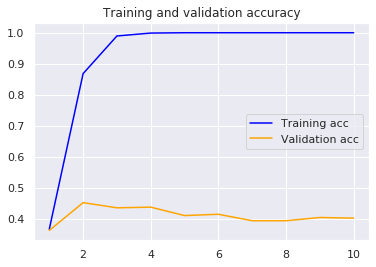

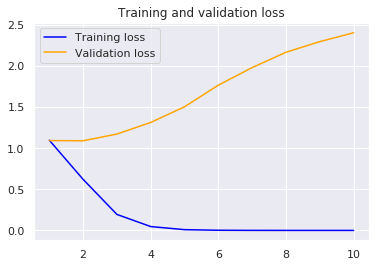

In [33]:
plotting(vector_model_history)

In [34]:
vector_model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 381us/step


[2.377296551068624, 0.4316666658719381]

Результат катастрофически ухудшился. Как я предполагаю, это может быть связано с малой выборкой в словаре, в который не входят опечатки и ошибки слов, которые, естесственно, встречаются в отзывах на КиноПоиске. В данном случае помог бы словарь, учитывающий эти случаи, и такой словарь существует, но он довольно тяжеловесный и я не стал с ним работать.

## Шаг 4. Рекуррентные сети.

Данный тип сети позволяет "запоминать" предыдущие состояния на этапе обучения. Поэтому результаты должны улучшиться. В модели я заменяю полносвязный слой Dense на слой LSTM.

In [149]:
from keras.layers import LSTM

LSTM_model = Sequential()
LSTM_model.add(Embedding(max_words, 32))
LSTM_model.add(LSTM(32))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 328,419
Trainable params: 328,419
Non-trainable params: 0
_________________________________________________________________


In [150]:
LSTM_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
LSTM_model_history = LSTM_model.fit(X_train, y_train,
                                    epochs=13,
                                    batch_size=128,
                                    validation_split=0.2)

Train on 1920 samples, validate on 480 samples
Epoch 1/13
1920/1920 [==============================] - 11s 6ms/step - loss: 1.0918 - acc: 0.4036 - val_loss: 1.0797 - val_acc: 0.5312
Epoch 2/13
1920/1920 [==============================] - 9s 4ms/step - loss: 1.0629 - acc: 0.5839 - val_loss: 0.9217 - val_acc: 0.5729
Epoch 3/13
1920/1920 [==============================] - 9s 5ms/step - loss: 0.8439 - acc: 0.6370 - val_loss: 0.8414 - val_acc: 0.5604
Epoch 4/13
1920/1920 [==============================] - 9s 4ms/step - loss: 0.7530 - acc: 0.6531 - val_loss: 0.7582 - val_acc: 0.6667
Epoch 5/13
1920/1920 [==============================] - 9s 5ms/step - loss: 0.6319 - acc: 0.7385 - val_loss: 0.7432 - val_acc: 0.6187
Epoch 6/13
1920/1920 [==============================] - 9s 5ms/step - loss: 0.5694 - acc: 0.7875 - val_loss: 0.6782 - val_acc: 0.6917
Epoch 7/13
1920/1920 [==============================] - 9s 5ms/step - loss: 0.5024 - acc: 0.8380 - val_loss: 0.6759 - val_acc: 0.6708
Epoch 8/13
192

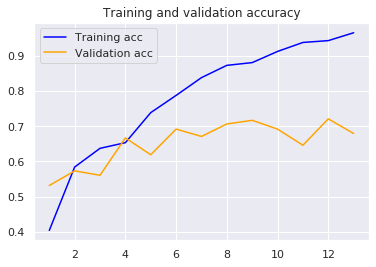

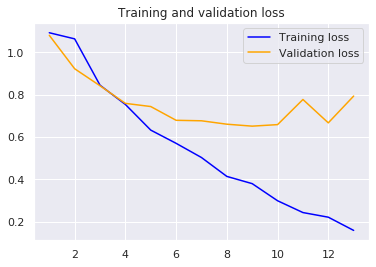

In [151]:
plotting(LSTM_model_history)

In [152]:
LSTM_model.evaluate(X_test, y_test)

600/600 [==============================] - 1s 2ms/step


[0.7488463282585144, 0.663333334128062]

Я несколько раз проводил обучение сети с разным количеством параметров, не забывая предварительно заново перемешивать данные, но в среднем результат не превышает 70 %. Что, конечно лучше, но все равно неудовлетворительно.

## Шаг 5. Исключение нейтральных отзывов.

Так или иначе, но анализ текста с помощью нейросетей основан на частотном анализе текста. Так что важную роль будет играть эмоциональная окраска слов. То есть, выразительные слова с положительной характеристикой едва ли будут часто встречатся в отрицательных отзывах и наоборот. Другое дело с нейтральными отзывами, которые, возможно, в целом не имеют эмоциональных фраз, а значит слова, используемые для нейтральной оценки могут равновероятно встречаться в любом типе отзывов, что сильно снижает качество классификации. Поэтому я удалю эти отзывы из датасета совсем и посмотрю, что получится.

In [0]:
binary_data = reviews[:2000]
binary_labels = [0 for _ in range(1000)] + [1 for _ in range(1000)]

In [0]:
max_len = 500
training_samples = 1500
max_words = 10000
binary_tokenizer = Tokenizer(num_words=max_words)
binary_tokenizer.fit_on_texts(binary_data)
binary_sequences = binary_tokenizer.texts_to_sequences(binary_data)
binary_word_index = binary_tokenizer.word_index
binary_data = pad_sequences(binary_sequences, maxlen=max_len)
binary_labels = np.asarray(binary_labels)
indices = np.arange(2000)
np.random.shuffle(indices)
binary_data = binary_data[indices]
binary_labels = binary_labels[indices]
binary_X_train = binary_data[:training_samples]
binary_y_train = binary_labels[:training_samples]
binary_X_test = binary_data[training_samples:]
binary_y_test = binary_labels[training_samples:]

In [156]:
binary_model = Sequential()
binary_model.add(Embedding(max_words, 32))
binary_model.add(LSTM(32))
binary_model.add(Dense(1, activation='sigmoid'))
binary_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])
binary_model_history = binary_model.fit(binary_X_train, binary_y_train,
                                        epochs=15,
                                        batch_size=128,
                                        validation_split=0.2)

Train on 1200 samples, validate on 300 samples
Epoch 1/15
1200/1200 [==============================] - 9s 8ms/step - loss: 0.6906 - acc: 0.5375 - val_loss: 0.6821 - val_acc: 0.6033
Epoch 2/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.7131 - acc: 0.6083 - val_loss: 0.6243 - val_acc: 0.8300
Epoch 3/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.5395 - acc: 0.8975 - val_loss: 0.5199 - val_acc: 0.8600
Epoch 4/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.4136 - acc: 0.9250 - val_loss: 0.5264 - val_acc: 0.8400
Epoch 5/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.3536 - acc: 0.9425 - val_loss: 0.4823 - val_acc: 0.8333
Epoch 6/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2842 - acc: 0.9750 - val_loss: 0.3140 - val_acc: 0.9167
Epoch 7/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2009 - acc: 0.9783 - val_loss: 0.4202 - val_acc: 0.8233
Epoch 8/15
1200

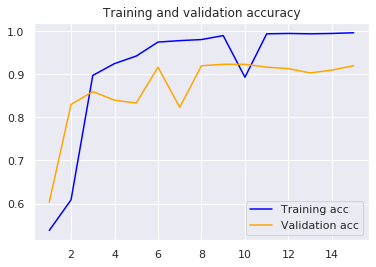

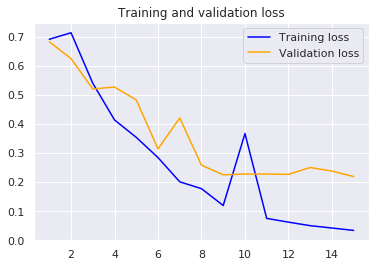

In [157]:
plotting(binary_model_history)

In [158]:
binary_model.evaluate(binary_X_test, binary_y_test)

500/500 [==============================] - 1s 2ms/step


[0.2188947651386261, 0.9259999995231628]

Поразительные 93 %. Уже думал, что и не получу такие цифры в этой работе. 

## Вывод

Для классификации отзывов по 3 категориям нет особой разницы, какой тип сети использовать, результат всегда был сравнительно низким (в шаге 4, как я уже упоминал, результат можно улучшить используя другой словарь). Для улучшения общего результата классификации необходимо провести обучение на большой выборке отзывов. Тем не менее, с бинарной классификацией нейросеть справляется хорошо даже с небольшой выборкой.